# MP5: Training Your Diffusion Model!

## Setup environment

In [50]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch # added
from torch import optim # added
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## Visualization helper function

In [51]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    """
    Visualize images as a grid and title the columns with the provided names.

    Args:
        images: (N, C, H, W) tensor of images, where N is (number of rows * number of columns)
        column_names: List of column names for the titles.

    Example usage:
    visualize_images_with_titles(torch.randn(16, 1, 32, 32), ['1', '2', '3', '4'])
    """
    num_images, num_columns = images.shape[0], len(column_names)
    assert num_images % num_columns == 0, 'Number of images must be a multiple of the number of columns.'

    num_rows = num_images // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1, num_rows * 1))

    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i < num_columns:
            ax.set_title(column_names[i % num_columns])

    plt.tight_layout()
    plt.show()


---
# Part 1: Training a Single-step Denoising UNet

## Implementing Simple and Composed Ops

In [52]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.down_conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn      = nn.BatchNorm2d(out_channels)
        self.gelu    = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.up_conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=7)
        self.gelu     = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.avg_pool(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
        self.bn      = nn.BatchNorm2d(in_channels)
        self.gelu    = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.unflatten(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        raise NotImplementedError()


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = DownConv(in_channels, out_channels)
        self.conv      = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.down_conv(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_conv = UpConv(in_channels, out_channels)
        self.conv    = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.up_conv(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()

## Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x = self.convblock1(x)
        x1 = x
        x = self.downblock1(x)
        x2 = x
        x = self.downblock2(x)
        x3 = x
        x = self.flatten(x)
        x = self.unflatten(x)
        x = torch.cat((x,x3),dim=1)
        x = self.upblock1(x)
        x = torch.cat((x,x2),dim=1)
        x = self.upblock2(x)
        x = torch.cat((x,x1),dim=1)
        x = self.convblock2(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()

## Visualizing the noising process

In [54]:
dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)

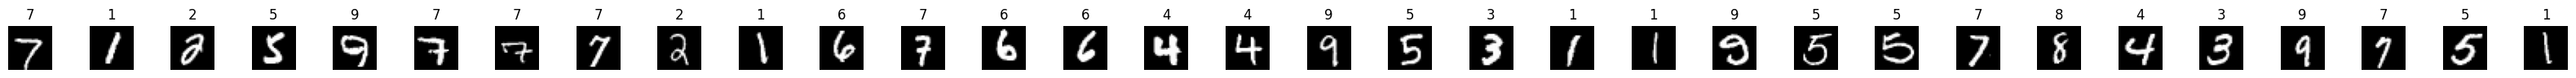

In [55]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
images, labels = next(iter(dataloader))
visualize_images_with_titles(images, [str(label.item()) for label in labels])

## Training a Single-Step Unconditional UNet

- Plot the loss curve
- Sample results on the test set

In [56]:
import torchvision.utils as vutils

In [115]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
loss_fn = nn.MSELoss()

num_epochs = 5

In [116]:
test_dataset = MNIST(root='data', download=True, transform=ToTensor(), train=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

Epoch [1/5], Loss: 0.0219
Epoch [2/5], Loss: 0.0110
Epoch [3/5], Loss: 0.0094
Epoch [4/5], Loss: 0.0087
Epoch [5/5], Loss: 0.0083


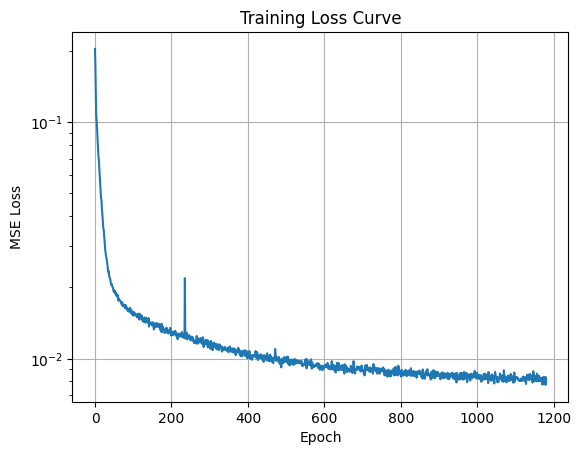

In [117]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
avg_loss_history = []
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        images, _ = batch  
        images = images.to(device)

        noisy_images = images + 0.5 * torch.randn_like(images)

        outputs = model(noisy_images)
        loss = loss_fn(outputs, images)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.yscale('log')
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

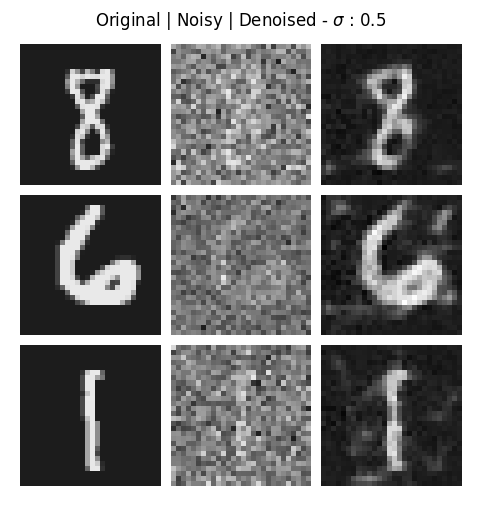

In [114]:
model.eval()
# test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

noisy_test_images = test_images + 0.7*torch.randn_like(test_images)

with torch.no_grad():
    denoised_images = model(noisy_test_images)
# Visualize: original noisy and denoised images

def show_image_triplets_columnwise(clean_imgs, noisy_imgs, denoised_imgs, num_images=3, sigma=0.5):
    """
    Show triplets (Clean, Noisy, Denoised) columnwise
    """
    clean_imgs = clean_imgs[:num_images]
    noisy_imgs = noisy_imgs[:num_images]
    noisy_imgs = (noisy_imgs - noisy_imgs.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0])
    noisy_imgs = noisy_imgs / (noisy_imgs.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0] + 1e-8)

    # Stack clean, noisy, denoised
    denoised_imgs = denoised_imgs[:num_images]

    # Stack them: (num_images, 3, C, H, W)
    triplets = torch.stack([clean_imgs, noisy_imgs, denoised_imgs], dim=1)  # (N, 3, C, H, W)
    
    # Now reshape to (3*num_images, C, H, W) for columnwise display
    triplets = triplets.view(-1, *clean_imgs.shape[1:])  # (3*N, C, H, W)

    # Make a grid
    grid = vutils.make_grid(triplets, nrow=3, pad_value=1.0, padding=2, normalize=True)

    plt.figure(figsize=(9, 2*num_images))
    img = grid.cpu().permute(1, 2, 0)
    plt.imshow(img)
    plt.title(f'Original | Noisy | Denoised - $\sigma$ : {sigma}')
    plt.axis('off')
    plt.show()

show_image_triplets_columnwise(test_images, noisy_test_images, denoised_images)

## Out-of-Distribution Testing

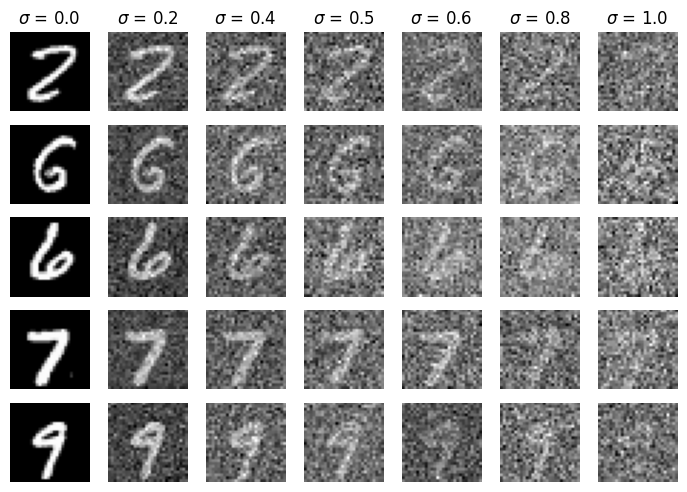

In [80]:
model.eval()
test_images, _ = next(iter(test_loader))
sigma_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
sampled_images_list = []
titles = []
test_images = test_images.to(device)

for i in sigma_list:
    sampled =  test_images + i*torch.randn_like(test_images)
    sampled_images_list.append(sampled)
    titles.append(f'$\sigma$ = {i}')

all_samples = torch.hstack(sampled_images_list)

axes = visualize_images_with_titles(all_samples, titles)

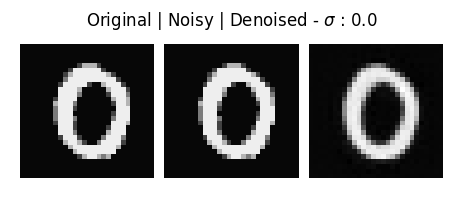

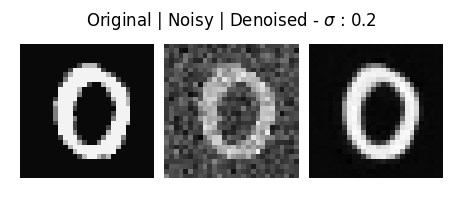

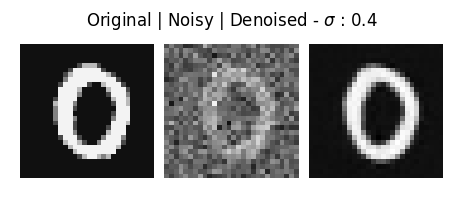

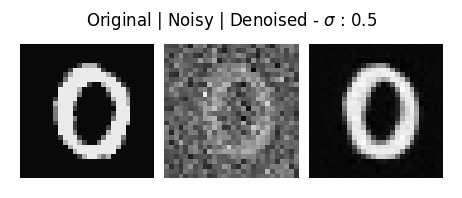

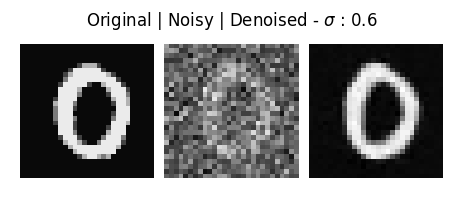

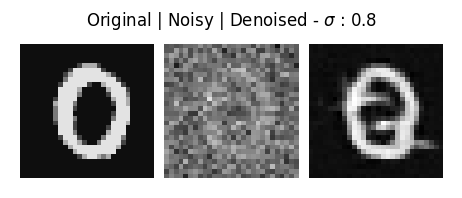

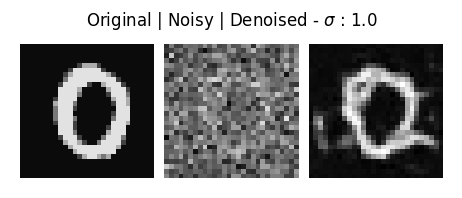

In [74]:
model.eval()
test_images, _ = next(iter(test_loader))

for sigma in [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0] :
    test_images = test_images.to(device)
    noisy_test_images = test_images + sigma*torch.randn_like(test_images)

    with torch.no_grad():
        denoised_images = model(noisy_test_images)

    show_image_triplets_columnwise(test_images, noisy_test_images, denoised_images, num_images=1, sigma=sigma)

---
# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x.unsqueeze(-1).unsqueeze(-1)
        raise NotImplementedError()


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)
        self.fcblock1   = FCBlock(1, 2*num_hiddens)
        self.fcblock2   = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x = self.convblock1(x)
        x1 = x
        x = self.downblock1(x)
        x2 = x
        x = self.downblock2(x)
        x3 = x
        x = self.flatten(x)
        x = self.unflatten(x) + self.fcblock1(t)
        x = torch.cat((x,x3),dim=1)
        x = self.upblock1(x) + self.fcblock2(t)
        x = torch.cat((x,x2),dim=1)
        x = self.upblock2(x)
        x = torch.cat((x,x1),dim=1)
        x = self.convblock2(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [120]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = torch.linspace(beta1, beta2, num_ts+1, device='cuda')
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        "betas"     : betas,
        "alphas"    : alphas,
        "alpha_bars": alpha_bars
    }
    raise NotImplementedError()

### Forward Pass : 

In [121]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    t = torch.randint(1,num_ts+1,size=(x_0.size(0),1),device="cuda")
    alpha_bar_t = ddpm_schedule["alpha_bars"][t.squeeze(-1)]
    alpha_bar_t = alpha_bar_t.view(-1,1,1,1)
    e = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar_t)*x_0 + torch.sqrt(1-alpha_bar_t)*e
    e_hat = unet(x_t, t.float()/num_ts)
    loss = nn.MSELoss()
    return loss(e,e_hat)
    raise NotImplementedError()

### Sampling

In [122]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    unet.eval()
    # YOUR CODE HERE.
    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alpha_bars = ddpm_schedule["alpha_bars"]
    N   = 5
    x_t = torch.randn(N,1,img_wh[0],img_wh[1],device='cuda')
    for t in range(num_ts,0,-1):
        alpha_t = alphas[t]
        beta_t  = betas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_t_1 = alpha_bars[t-1]
        if t>1 :
            z = torch.randn_like(x_t,device='cuda')
        else :
            z = torch.zeros_like(x_t)

        x_0_hat = (x_t - torch.sqrt(torch.abs(1-alpha_bar_t))*unet(x_t, t/num_ts*torch.ones((N,1),device='cuda')))/torch.sqrt(torch.abs(alpha_bar_t))
        x_t =   ( torch.sqrt(torch.abs(alpha_bar_t_1))*beta_t*x_0_hat + torch.sqrt(torch.abs(alpha_t))*(1-alpha_bar_t_1)*x_t )/((1-alpha_bar_t)+1e-5) + torch.sqrt(torch.abs(beta_t))*z

    return x_t
    raise NotImplementedError()

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

### Training the Time-conditioned UNet

- Plot the loss curve
- Sample results on the test set

Epoch [1/20] Batch [0] Loss: 1.1082
Epoch [1/20] Batch [100] Loss: 0.0733
Epoch [1/20] Batch [200] Loss: 0.0479
Epoch [1/20] Batch [300] Loss: 0.0500
Epoch [1/20] Batch [400] Loss: 0.0459
Epoch [1/20] Avg Loss: 0.0674
Model saved at epoch 1
Epoch [2/20] Batch [0] Loss: 0.0390
Epoch [2/20] Batch [100] Loss: 0.0355
Epoch [2/20] Batch [200] Loss: 0.0371
Epoch [2/20] Batch [300] Loss: 0.0401
Epoch [2/20] Batch [400] Loss: 0.0352
Epoch [2/20] Avg Loss: 0.0419
Epoch [3/20] Batch [0] Loss: 0.0437
Epoch [3/20] Batch [100] Loss: 0.0453
Epoch [3/20] Batch [200] Loss: 0.0350
Epoch [3/20] Batch [300] Loss: 0.0338
Epoch [3/20] Batch [400] Loss: 0.0354
Epoch [3/20] Avg Loss: 0.0365
Epoch [4/20] Batch [0] Loss: 0.0337
Epoch [4/20] Batch [100] Loss: 0.0350
Epoch [4/20] Batch [200] Loss: 0.0373
Epoch [4/20] Batch [300] Loss: 0.0345
Epoch [4/20] Batch [400] Loss: 0.0337
Epoch [4/20] Avg Loss: 0.0341
Epoch [5/20] Batch [0] Loss: 0.0347
Epoch [5/20] Batch [100] Loss: 0.0324
Epoch [5/20] Batch [200] Loss: 

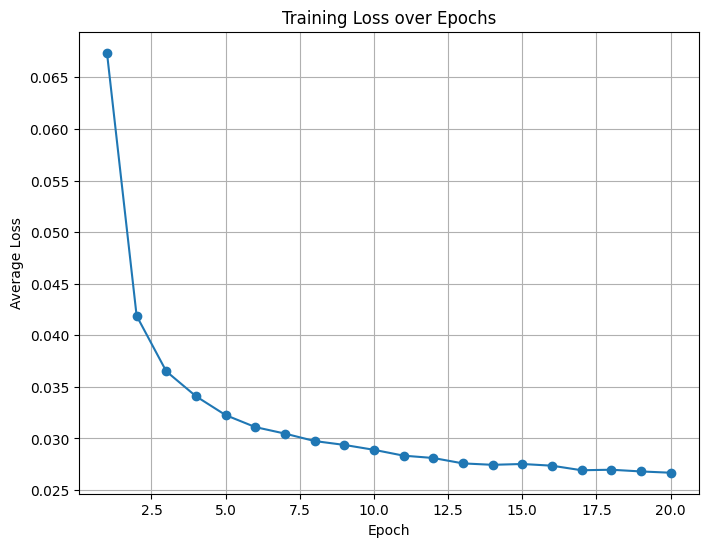

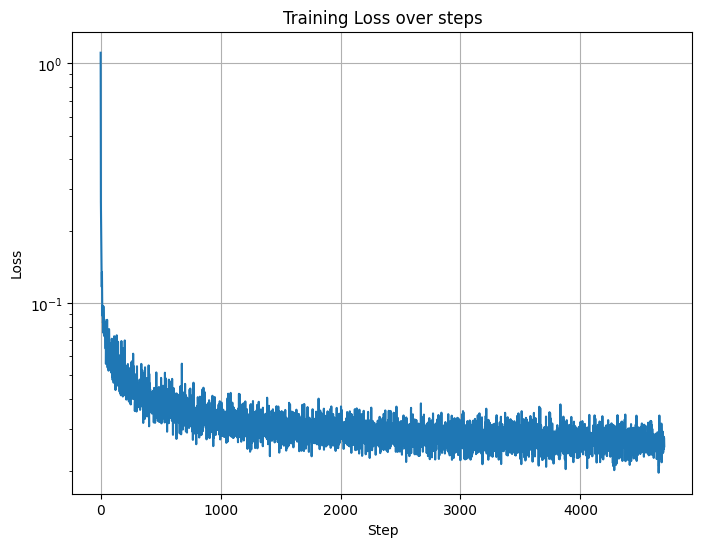

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300).to(device)

epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/epochs))

epoch_losses = []
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()
        loss = model(x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
        if batch_idx % 2 == 0 : 
            losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

    scheduler.step()
    
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0 or epoch+1 == 1:
        torch.save(model.state_dict(), f"./models/model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

print("Training complete!")

plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(losses)
plt.xlabel('Step')
plt.yscale('log')
plt.ylabel('Loss')
plt.title('Training Loss over steps')
plt.grid(True)
plt.show()

In [60]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    num_images, num_columns = images.shape[0], len(column_names)
    fig, axes = plt.subplots(num_images, num_columns, figsize=(num_columns,num_images))

    for i, axr in enumerate(axes):
        for j, axc in enumerate(axr):
            img = images[i,j].cpu().numpy()  

            axc.imshow(img, cmap='gray')
            axc.axis('off')

            if i == 0:  
                axc.set_title(column_names[j])

    plt.tight_layout(pad=1)
    plt.show()

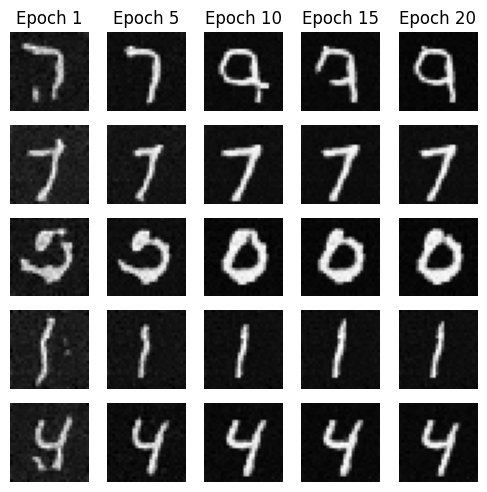

In [ ]:
unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300).to(device)

epoch_list = [1] + [i for i in range(5, epochs+1, 5)]
sampled_images_list = []
titles = []

for i in epoch_list:
    model.load_state_dict(torch.load(f"./models/model_epoch_{i}.pth"))
    sampled = ddpm_sample(unet=model.unet, ddpm_schedule=model.ddpm_schedule, img_wh=(28, 28), num_ts=model.num_ts, seed=2)
    sampled_images_list.append(sampled)
    titles.append(f'Epoch {i}')

all_samples = torch.hstack(sampled_images_list)

axes = visualize_images_with_titles(all_samples, titles)

---
## Implementing class-conditioned UNet

In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [127]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x.unsqueeze(-1).unsqueeze(-1)
        
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)
        self.fcblock1   = FCBlock(1, 2*num_hiddens)
        self.fcblock2   = FCBlock(1, num_hiddens)
        self.fcblock3   = FCBlock(num_classes, 2*num_hiddens)
        self.fcblock4   = FCBlock(num_classes,   num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        c = F.one_hot(c, num_classes=10).float()
        if mask is not None : 
            c = c*mask.unsqueeze(-1)
        x = self.convblock1(x)
        x1 = x
        x = self.downblock1(x)
        x2 = x
        x = self.downblock2(x)
        x3 = x
        x = self.flatten(x)
        x = self.fcblock3(c)*self.unflatten(x) + self.fcblock1(t)
        x = torch.cat((x,x3),dim=1)
        x = self.fcblock4(c)*self.upblock1(x) + self.fcblock2(t)
        x = torch.cat((x,x2),dim=1)
        x = self.upblock2(x)
        x = torch.cat((x,x1),dim=1)
        x = self.convblock2(x)
        x = self.conv(x)
        return x

In [128]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    t = torch.randint(1,num_ts+1,size=(x_0.size(0),1),device="cuda")
    alpha_bar_t = ddpm_schedule["alpha_bars"][t.squeeze(-1)]
    alpha_bar_t = alpha_bar_t.view(-1,1,1,1)
    mask = (torch.rand(x_0.size(0), device='cuda') > p_uncond).float()
    e = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar_t)*x_0 + torch.sqrt(1-alpha_bar_t)*e
    e_hat = unet(x=x_t, t=t.float()/num_ts, c=c, mask=mask)
    loss = nn.MSELoss()
    return loss(e,e_hat)
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Algorithm 2 of the DDPM paper with classifier-free guidance + animation.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) all intermediate states for animation.
    """
    unet.eval()
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alpha_bars = ddpm_schedule["alpha_bars"]

    N = c.size(0)
    x_t = torch.randn(N, 1, img_wh[0], img_wh[1], device='cuda')

    frames = [x_t.clone()]  

    for t in range(num_ts, 0, -1):
        alpha_t = alphas[t]
        beta_t = betas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_t_1 = alpha_bars[t-1]

        if t > 1:
            z = torch.randn_like(x_t, device='cuda')
        else:
            z = torch.zeros_like(x_t)

        s = t / num_ts * torch.ones((N, 1), device="cuda")

        eps_u = unet(x=x_t, t=s, c=c, mask=torch.zeros(N, device='cuda'))
        eps_c = unet(x=x_t, t=s, c=c, mask=torch.ones(N, device='cuda'))
        eps = eps_u + guidance_scale * (eps_c - eps_u)

        x_0_hat = (x_t - torch.sqrt(torch.abs(1 - alpha_bar_t)) * eps) / torch.sqrt(torch.abs(alpha_bar_t))
        x_t = (
            torch.sqrt(torch.abs(alpha_bar_t_1)) * beta_t * x_0_hat
            + torch.sqrt(torch.abs(alpha_t)) * (1 - alpha_bar_t_1) * x_t
        ) / (1 - alpha_bar_t + 1e-5) + torch.sqrt(torch.abs(beta_t)) * z

        frames.append(x_t.clone())  

    animation = torch.stack(frames, dim=1)

    return x_t, animation

In [ ]:
## GIF Generation

import torchvision.utils as vutils
import torchvision.transforms.functional as TF

def normalize_per_frame(frame: torch.Tensor) -> torch.Tensor:
    min_val = frame.amin(dim=(1, 2), keepdim=True)
    max_val = frame.amax(dim=(1, 2), keepdim=True)
    return (frame - min_val) / (max_val - min_val + 1e-8)

def save_ddpm_animation(
    animation: torch.Tensor,
    filename: str = "ddpm_animation.gif",
    total_duration_sec: int = 1,
    max_frames: int = 50,
    freeze_last_frame_sec: float = 1.0,
):

    animation = animation.detach().cpu()
    N, T, C, H, W = animation.shape

    step = max(1, T // max_frames)
    frames = []
    for t in range(0, T, step):
        frame_batch = animation[:, t]  # (N, C, H, W)
        normalized = torch.stack([normalize_per_frame(img) for img in frame_batch])
        grid = vutils.make_grid(normalized, nrow=N, padding=2)
        grid = grid[0, :, :].unsqueeze(0)
        img = TF.to_pil_image(grid.squeeze(0), mode='L')
        img = img.convert('P')

        frames.append(img)

    anim_duration_ms = int(1000 * total_duration_sec / len(frames))

    freeze_frame = frames[-1]
    freeze_repeats = int(1000 * freeze_last_frame_sec / anim_duration_ms)
    frames.extend([freeze_frame] * freeze_repeats)

    frames[0].save( filename, save_all=True, append_images=frames[1:], duration=anim_duration_ms, loop=0,  optimize=False)
    print(f"Saved GIF to {filename} with {len(frames)} frames ({anim_duration_ms} ms/frame).")

In [131]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

## Training the Class-conditioned UNet

- Plot the loss curve
- Sample results on the test set

Epoch [1/20] Batch [0] Loss: 1.2332
Epoch [1/20] Batch [100] Loss: 0.0624
Epoch [1/20] Batch [200] Loss: 0.0479
Epoch [1/20] Batch [300] Loss: 0.0478
Epoch [1/20] Batch [400] Loss: 0.0611
Epoch [1/20] Avg Loss: 0.0709
Model saved at epoch 1
Epoch [2/20] Batch [0] Loss: 0.0405
Epoch [2/20] Batch [100] Loss: 0.0489
Epoch [2/20] Batch [200] Loss: 0.0478
Epoch [2/20] Batch [300] Loss: 0.0416
Epoch [2/20] Batch [400] Loss: 0.0363
Epoch [2/20] Avg Loss: 0.0429
Epoch [3/20] Batch [0] Loss: 0.0482
Epoch [3/20] Batch [100] Loss: 0.0339
Epoch [3/20] Batch [200] Loss: 0.0382
Epoch [3/20] Batch [300] Loss: 0.0323
Epoch [3/20] Batch [400] Loss: 0.0369
Epoch [3/20] Avg Loss: 0.0381
Epoch [4/20] Batch [0] Loss: 0.0331
Epoch [4/20] Batch [100] Loss: 0.0434
Epoch [4/20] Batch [200] Loss: 0.0311
Epoch [4/20] Batch [300] Loss: 0.0336
Epoch [4/20] Batch [400] Loss: 0.0332
Epoch [4/20] Avg Loss: 0.0356
Epoch [5/20] Batch [0] Loss: 0.0363
Epoch [5/20] Batch [100] Loss: 0.0368
Epoch [5/20] Batch [200] Loss: 

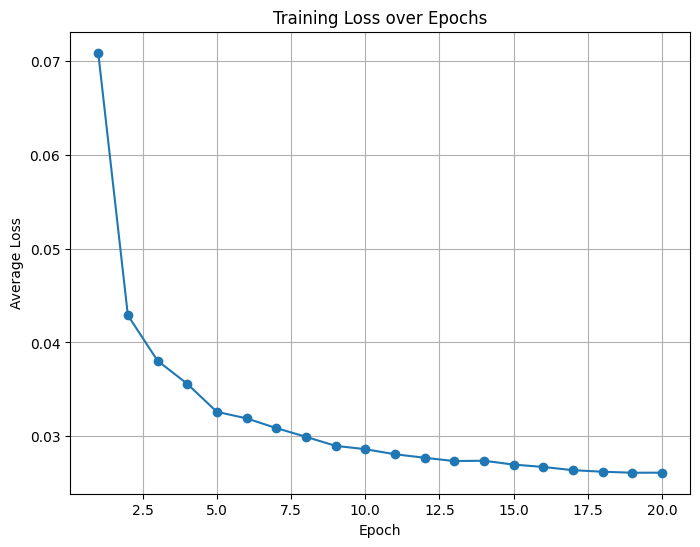

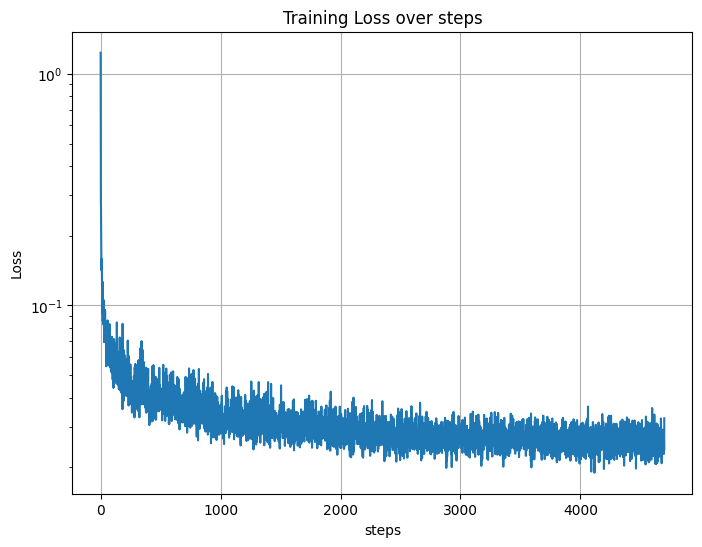

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO
device = 'cuda' if torch.cuda.is_available() else 'cpu'

unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300, p_uncond=0.1).to(device)

epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/epochs))

epoch_losses = []
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, (x, labels) in enumerate(dataloader):
        x = x.to(device)
        labels = labels.to(device, dtype=torch.int64)

        optimizer.zero_grad()
        loss = model(x, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 2 == 0 : 
            losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

    scheduler.step()
    
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0 or epoch+1 == 1:
        torch.save(model.state_dict(), f"./cls_cond_models/model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

print("Training complete!")

plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(losses)
plt.xlabel('steps')
plt.yscale('log')
plt.ylabel('Loss')
plt.title('Training Loss over steps')
plt.grid(True)
plt.show()

### Sampling + Extra Credits GIF Generation

In [133]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    num_images, num_columns = images.shape[0], len(column_names)
    fig, axes = plt.subplots(num_images, num_columns, figsize=(0.95*num_columns,num_images))

    for i, axr in enumerate(axes):
        for j, axc in enumerate(axr):
            img = images[i,j].cpu().numpy()  

            axc.imshow(img, cmap='gray')
            axc.axis('off')

            if i == 0:  
                axc.set_title(column_names[j])

    plt.tight_layout(pad=0)
    plt.show()

Saved GIF to ddpm_sampling_1.gif with 156 frames (19 ms/frame).
Saved GIF to ddpm_sampling_5.gif with 156 frames (19 ms/frame).
Saved GIF to ddpm_sampling_10.gif with 156 frames (19 ms/frame).
Saved GIF to ddpm_sampling_15.gif with 156 frames (19 ms/frame).
Saved GIF to ddpm_sampling_20.gif with 156 frames (19 ms/frame).


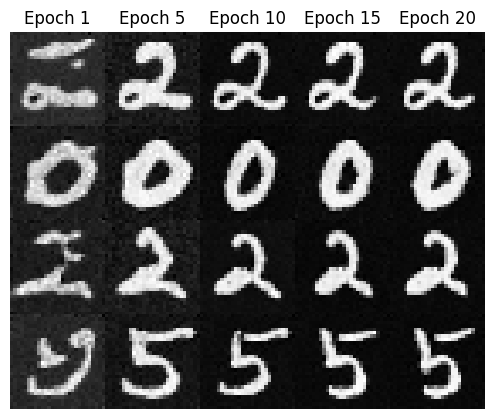

In [ ]:
unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300, p_uncond=0.1).to(device)

epoch_list = [1] + [i for i in range(5, epochs+1, 5)]
sampled_images_list = []
titles = []
c = torch.randint(0,10,size=(5,),device=device,dtype=torch.int64) 
c = torch.tensor([2,0,2,5],dtype=torch.int64, device=device)

for i in epoch_list:
    model.load_state_dict(torch.load(f"./cls_cond_models/model_epoch_{i}.pth"))
    sampled, animation = model.sample(c=c,img_wh=(28, 28), seed=1)
    sampled_images_list.append(sampled)
    titles.append(f'Epoch {i}')
    # save_ddpm_animation(animation, f"ddpm_sampling_{i}.gif", total_duration_sec=1)
    save_ddpm_animation(animation, f"ddpm_sampling_{i}.gif", total_duration_sec=1, freeze_last_frame_sec=2,max_frames=50)

all_samples = torch.hstack(sampled_images_list)

axes = visualize_images_with_titles(all_samples, titles)

## Extra Credits : Digit Classifier

In [136]:
from torchvision import transforms
import torch.optim as optim

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([ transforms.ToTensor() ])

train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset  = MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [137]:
for epoch in range(20): 
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Train Acc: {acc:.4f}")

Epoch 1, Loss: 167.1055, Train Acc: 0.9465
Epoch 2, Loss: 46.5718, Train Acc: 0.9845
Epoch 3, Loss: 33.0304, Train Acc: 0.9892
Epoch 4, Loss: 23.6712, Train Acc: 0.9923
Epoch 5, Loss: 19.5774, Train Acc: 0.9932
Epoch 6, Loss: 14.6149, Train Acc: 0.9947
Epoch 7, Loss: 12.8404, Train Acc: 0.9955
Epoch 8, Loss: 9.5488, Train Acc: 0.9968
Epoch 9, Loss: 9.2326, Train Acc: 0.9968
Epoch 10, Loss: 7.7114, Train Acc: 0.9972
Epoch 11, Loss: 5.4378, Train Acc: 0.9980
Epoch 12, Loss: 5.3533, Train Acc: 0.9980
Epoch 13, Loss: 5.8896, Train Acc: 0.9978
Epoch 14, Loss: 3.4754, Train Acc: 0.9988
Epoch 15, Loss: 5.1009, Train Acc: 0.9980
Epoch 16, Loss: 3.5988, Train Acc: 0.9986
Epoch 17, Loss: 2.7178, Train Acc: 0.9988
Epoch 18, Loss: 2.0674, Train Acc: 0.9993
Epoch 19, Loss: 2.3118, Train Acc: 0.9991
Epoch 20, Loss: 3.8013, Train Acc: 0.9987


In [138]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {correct / len(test_loader.dataset):.4f}")

Test Accuracy: 0.9907


In [ ]:
indices = torch.randint(0,1000,size=(5,))
c = preds[indices]
print("predicted : ",c)
print("correct : ",labels[indices])

predicted :  tensor([9, 2, 1, 8, 7], device='cuda:0')
correct :  tensor([9, 2, 1, 8, 7], device='cuda:0')


tensor([9, 2, 1, 8, 7], device='cuda:0')


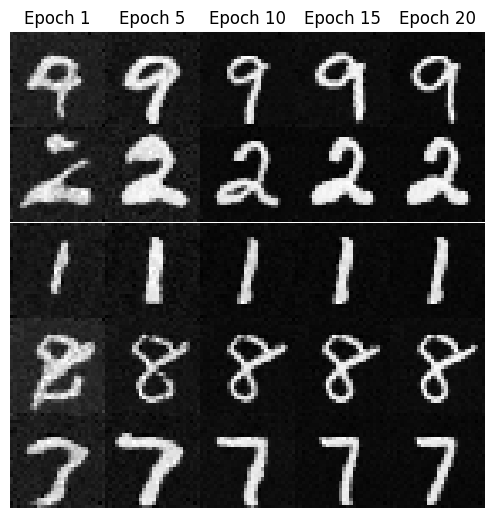

In [141]:
epochs = 20
unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300, p_uncond=0.1).to(device)

epoch_list = [1] + [i for i in range(5, epochs+1, 5)]
sampled_images_list = []
titles = []

for i in epoch_list:
    model.load_state_dict(torch.load(f"./cls_cond_models/model_epoch_{i}.pth"))
    sampled, animation = model.sample(c=c,img_wh=(28, 28), seed=1)
    sampled_images_list.append(sampled)
    titles.append(f'Epoch {i}')
    # save_ddpm_animation(animation, f"ddpm_sampling_{i}.gif", total_duration_sec=1)
    # save_ddpm_animation(animation, f"extra_credits_{i}.gif", total_duration_sec=1, freeze_last_frame_sec=2,max_frames=50)

all_samples = torch.hstack(sampled_images_list)

print(c)
axes = visualize_images_with_titles(all_samples, titles)

## Extra Credits : training on CIFAR 100

In [11]:
from torchvision.datasets import CIFAR100

In [12]:
dataset = CIFAR100(root="CIFAR100", download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=8, stride=8, padding=0)
        self.bn      = nn.BatchNorm2d(in_channels)
        self.gelu    = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.unflatten(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


In [ ]:
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 3, kernel_size=3, stride=1, padding=1)
        self.fcblock1   = FCBlock(1, 2*num_hiddens)
        self.fcblock2   = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (32,32), "Expect input shape to be (28, 28)."
        x = self.convblock1(x)
        x1 = x
        x = self.downblock1(x)
        x2 = x
        x = self.downblock2(x)
        x3 = x
        x = self.flatten(x)
        x = self.unflatten(x) + self.fcblock1(t)
        x = torch.cat((x,x3),dim=1)
        x = self.upblock1(x) + self.fcblock2(t)
        x = torch.cat((x,x2),dim=1)
        x = self.upblock2(x)
        x = torch.cat((x,x1),dim=1)
        x = self.convblock2(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    unet.eval()
    # YOUR CODE HERE.
    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alpha_bars = ddpm_schedule["alpha_bars"]
    N   = 5
    x_t = torch.randn(N,3,img_wh[0],img_wh[1],device='cuda')
    for t in range(num_ts,0,-1):
        alpha_t = alphas[t]
        beta_t  = betas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_t_1 = alpha_bars[t-1]
        if t>1 :
            z = torch.randn_like(x_t,device='cuda')
        else :
            z = torch.zeros_like(x_t)

        x_0_hat = (x_t - torch.sqrt(torch.abs(1-alpha_bar_t))*unet(x_t, t/num_ts*torch.ones((N,1),device='cuda')))/torch.sqrt(torch.abs(alpha_bar_t))
        x_t =   ( torch.sqrt(torch.abs(alpha_bar_t_1))*beta_t*x_0_hat + torch.sqrt(torch.abs(alpha_t))*(1-alpha_bar_t_1)*x_t )/((1-alpha_bar_t)+1e-5) + torch.sqrt(torch.abs(beta_t))*z

    return x_t
    raise NotImplementedError()

#### Training

In [13]:
unet = TimeConditionalUNet(in_channels=3, num_classes=1, num_hiddens=512).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300).to(device)

epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/epochs))

Epoch [1/20] Batch [0] Loss: 1.1461
Epoch [1/20] Batch [100] Loss: 0.0746
Epoch [1/20] Batch [200] Loss: 0.0737
Epoch [1/20] Batch [300] Loss: 0.0557
Epoch [1/20] Avg Loss: 0.1319
Model saved at epoch 1
Epoch [2/20] Batch [0] Loss: 0.0568
Epoch [2/20] Batch [100] Loss: 0.0509
Epoch [2/20] Batch [200] Loss: 0.0606
Epoch [2/20] Batch [300] Loss: 0.0488
Epoch [2/20] Avg Loss: 0.0559
Epoch [3/20] Batch [0] Loss: 0.0529
Epoch [3/20] Batch [100] Loss: 0.0382
Epoch [3/20] Batch [200] Loss: 0.0653
Epoch [3/20] Batch [300] Loss: 0.0632
Epoch [3/20] Avg Loss: 0.0507
Epoch [4/20] Batch [0] Loss: 0.0572
Epoch [4/20] Batch [100] Loss: 0.0473
Epoch [4/20] Batch [200] Loss: 0.0446
Epoch [4/20] Batch [300] Loss: 0.0543
Epoch [4/20] Avg Loss: 0.0473
Epoch [5/20] Batch [0] Loss: 0.0425
Epoch [5/20] Batch [100] Loss: 0.0369
Epoch [5/20] Batch [200] Loss: 0.0469
Epoch [5/20] Batch [300] Loss: 0.0611
Epoch [5/20] Avg Loss: 0.0452
Model saved at epoch 5
Epoch [6/20] Batch [0] Loss: 0.0455
Epoch [6/20] Batch

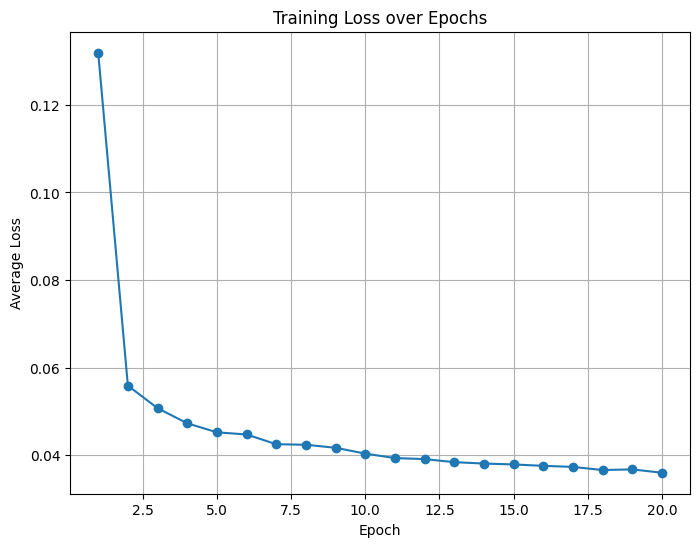

In [ ]:
epoch_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()
        loss = model(x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

    scheduler.step()
    
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0 or epoch+1 == 1:
        torch.save(model.state_dict(), f"./models/model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

print("Training complete!")

plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [ ]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    assert images.dim() == 5, "Expected shape (rows, cols, 3, H, W)"
    rows, cols = images.shape[:2]
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.8*rows))

    if rows == 1:
        axes = [axes]  
    if cols == 1:
        axes = [[ax] for ax in axes]  

    for i in range(rows):
        for j in range(cols):
            img = images[i, j].detach().cpu().permute(1, 2, 0)  

            ax = axes[i][j]
            ax.imshow(img.clamp(0, 1))  
            ax.axis('off')

            if i == 0:
                ax.set_title(column_names[j], fontsize=10)

    plt.tight_layout(pad=0.1)
    plt.show()


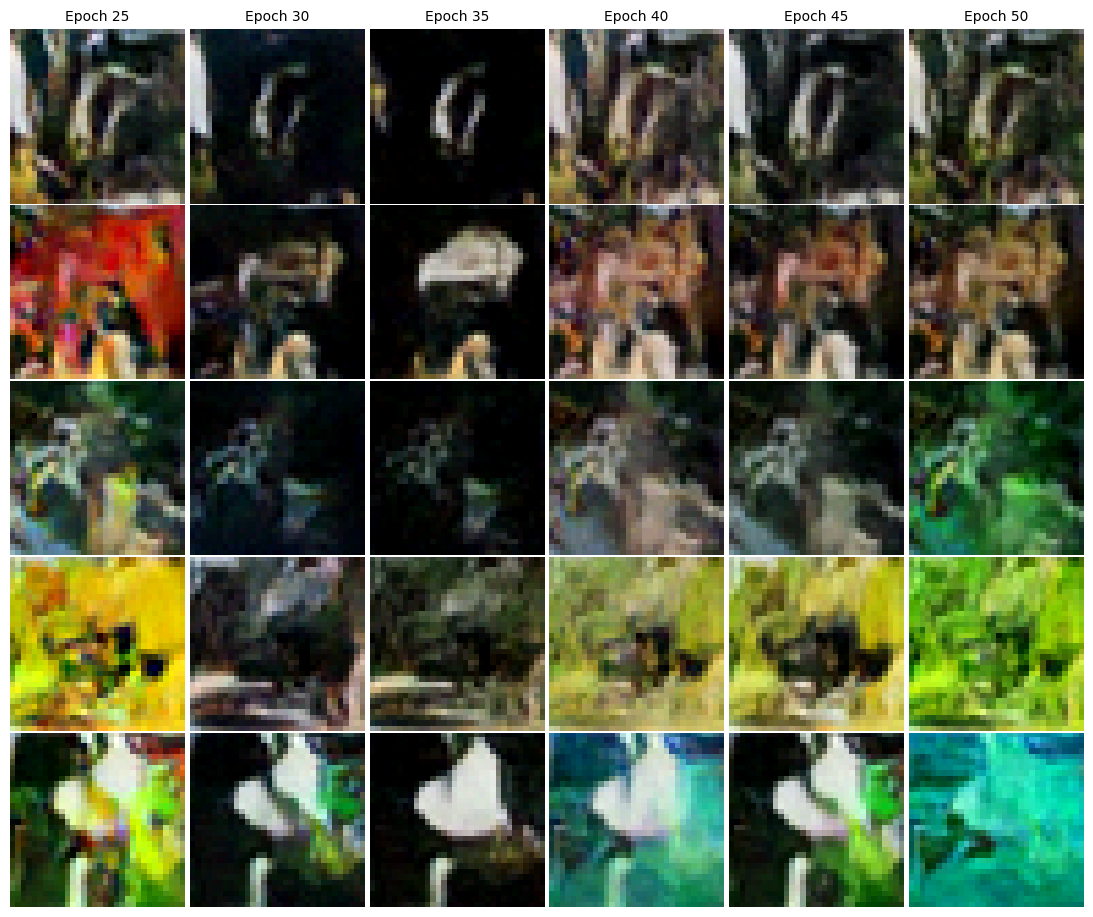

In [128]:
unet = TimeConditionalUNet(in_channels=3, num_classes=1, num_hiddens=256).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=500).to(device)

epoch_list = [1] + [i for i in range(5, epochs+1, 5)]
epoch_list = [i for i in range(25, 50+1, 5)]
sampled_images_list = []
titles = []

for i in epoch_list:
    model.load_state_dict(torch.load(f"./models/model_epoch_{i}.pth"))
    sampled = ddpm_sample(unet=model.unet, ddpm_schedule=model.ddpm_schedule, img_wh=(32, 32), num_ts=model.num_ts, seed=5)
    sampled_images_list.append(sampled)
    titles.append(f'Epoch {i}')

all_samples = torch.stack(sampled_images_list,dim=1)

axes = visualize_images_with_titles(all_samples, titles)

## Extra Credits : Modified Unet architecture

In [2]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.down_conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.gelu    = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.up_conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=7) # MODIFY according to image input size
        self.gelu     = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.avg_pool(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0) # MODIFY according to image input size
        self.bn   = nn.BatchNorm2d(in_channels)
        self.gelu    = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.unflatten(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x
        raise NotImplementedError()


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        res = x
        x = self.conv2(x)
        return x + res
        raise NotImplementedError()


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = DownConv(in_channels, out_channels)
        self.conv      = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.down_conv(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_conv = UpConv(in_channels, out_channels)
        self.conv    = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.up_conv(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()

class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x.unsqueeze(-1).unsqueeze(-1)

In [ ]:
def sinusoidal_embedding(timesteps: torch.Tensor, dim: int):
    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000, device='cuda')) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device='cuda') * -emb)
    emb = timesteps * emb[None, :] 
    emb = torch.cat((emb.sin(), emb.cos()), dim=1)  
    return emb

class TimeEmbedding(nn.Module) : 
    def __init__(self, out):
        super().__init__()
        self.fc1 = nn.Linear(out, out)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out, out)
    
    def forward(self, x) : 
        x = sinusoidal_embedding(x,self.fc1.in_features)
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x.unsqueeze(-1).unsqueeze(-1)


In [ ]:
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock1a = ConvBlock(num_hiddens, num_hiddens) # Mod
        self.convblock1b = ConvBlock(num_hiddens, num_hiddens)

        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.convblock2a = ConvBlock(num_hiddens, num_hiddens) # Mod
        self.convblock2b = ConvBlock(num_hiddens, num_hiddens)

        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(2*num_hiddens, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten    = Flatten()
        self.unflatten  = Unflatten(2*num_hiddens)
        self.upblock1   = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2   = UpBlock(2*num_hiddens, num_hiddens)
        self.conv       = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1) # MODIFY channels accordingly
        # self.fcblock1   = FCBlock(1, 2*num_hiddens)
        # self.fcblock2   = FCBlock(1, num_hiddens)
        # Sinusoidal Time embedding
        self.fcblock1   = TimeEmbedding(2*num_hiddens)
        self.fcblock2   = TimeEmbedding(num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        assert x.shape[-2:] == (28,28), "Expect input shape to be (28, 28)."
        x = self.convblock1(x)
        x = self.convblock1a(x)
        x = self.convblock1b(x)
        x1 = x

        x = self.downblock1(x)
        x2 = x
        x = self.downblock2(x)
        x3 = x
        # Neck
        x = self.flatten(x)
        x = self.unflatten(x) + self.fcblock1(t)
        # Upscaling
        x = torch.cat((x,x3),dim=1)
        x = self.upblock1(x) + self.fcblock2(t)
        x = torch.cat((x,x2),dim=1)
        x = self.upblock2(x)
        x = torch.cat((x,x1),dim=1)
        x = self.convblock2(x) + x1
        # Skip Connection : 
        x = self.convblock2a(x)
        x = self.convblock2b(x)
        x = self.conv(x)
        return x
        raise NotImplementedError()

### Training

In [25]:
unet = TimeConditionalUNet(in_channels=3, num_classes=1, num_hiddens=128).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300).to(device)

epochs = 60
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min = 1e-8)

Epoch [1/60] Batch [0] Loss: 2.2206
Epoch [1/60] Batch [100] Loss: 0.1032
Epoch [1/60] Batch [200] Loss: 0.1029
Epoch [1/60] Batch [300] Loss: 0.0690
Epoch [1/60] Avg Loss: 0.1248
Model saved at epoch 1
Epoch [2/60] Batch [0] Loss: 0.1096
Epoch [2/60] Batch [100] Loss: 0.0522
Epoch [2/60] Batch [200] Loss: 0.0604
Epoch [2/60] Batch [300] Loss: 0.0562
Epoch [2/60] Avg Loss: 0.0634
Epoch [3/60] Batch [0] Loss: 0.0653
Epoch [3/60] Batch [100] Loss: 0.0554
Epoch [3/60] Batch [200] Loss: 0.0393
Epoch [3/60] Batch [300] Loss: 0.0587
Epoch [3/60] Avg Loss: 0.0564
Epoch [4/60] Batch [0] Loss: 0.0518
Epoch [4/60] Batch [100] Loss: 0.0415
Epoch [4/60] Batch [200] Loss: 0.0470
Epoch [4/60] Batch [300] Loss: 0.0495
Epoch [4/60] Avg Loss: 0.0524
Epoch [5/60] Batch [0] Loss: 0.0419
Epoch [5/60] Batch [100] Loss: 0.0432
Epoch [5/60] Batch [200] Loss: 0.0415
Epoch [5/60] Batch [300] Loss: 0.0435
Epoch [5/60] Avg Loss: 0.0498
Model saved at epoch 5
Epoch [6/60] Batch [0] Loss: 0.0459
Epoch [6/60] Batch

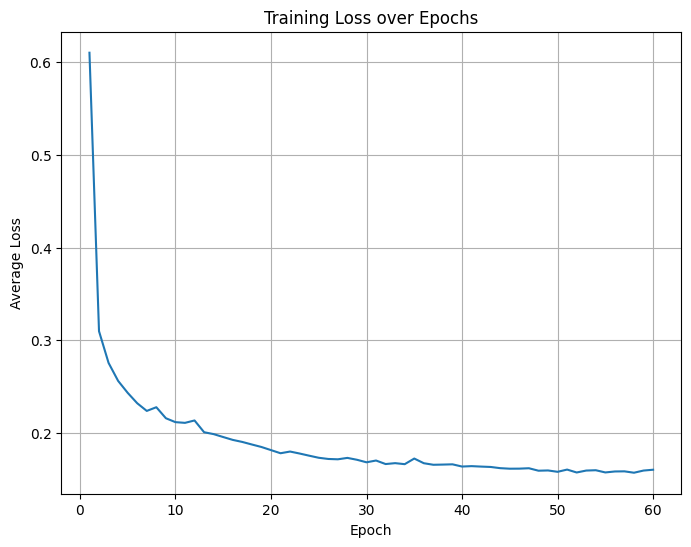

In [ ]:
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()
        loss = model(x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

    scheduler.step()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(total_loss/x.size(0))
    
    print(f"Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0 or epoch+1 == 1:
        torch.save(model.state_dict(), f"./models/model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

print("Training complete!")

plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [29]:
model.load_state_dict(torch.load(f"./models/model_epoch_{60}.pth"))

<All keys matched successfully>

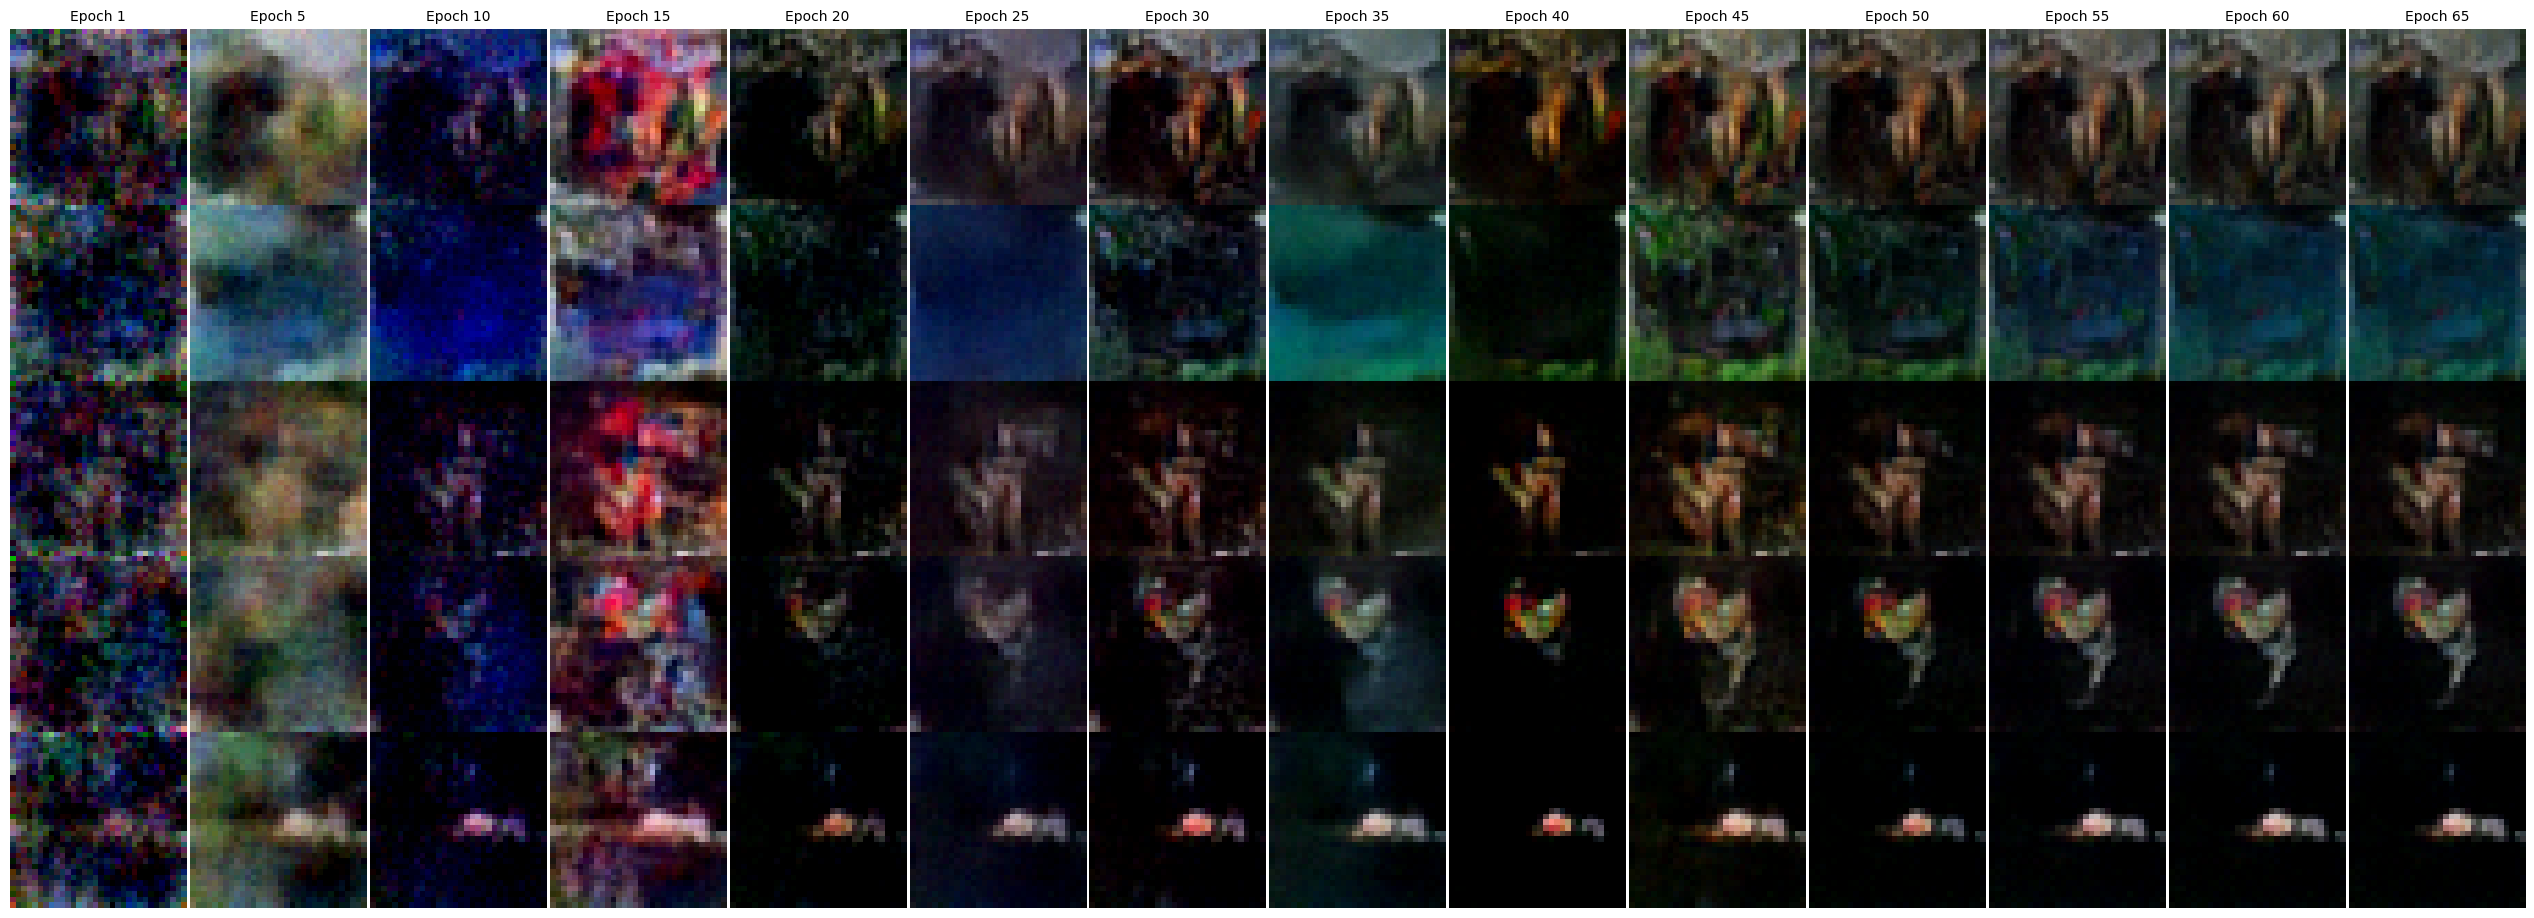

In [42]:
unet = TimeConditionalUNet(in_channels=3, num_classes=1, num_hiddens=128).to(device)
model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300).to(device)

epoch_list = [1] + [i for i in range(5, 70, 5)]
# epoch_list = [i for i in range(0, 50+1, 5)]
sampled_images_list = []
titles = []

for i in epoch_list:
    model.load_state_dict(torch.load(f"./models/model_epoch_{i}.pth"))
    sampled = ddpm_sample(unet=model.unet, ddpm_schedule=model.ddpm_schedule, img_wh=(32, 32), num_ts=model.num_ts, seed=0)
    sampled_images_list.append(sampled)
    titles.append(f'Epoch {i}')

all_samples = torch.stack(sampled_images_list,dim=1)

axes = visualize_images_with_titles(all_samples, titles)

## Rectified Flow : 

In [ ]:
def rectified_flow_forward(
    unet: TimeConditionalUNet,
    x_0: torch.Tensor,
) -> torch.Tensor:
    unet.train()
    batch_size = x_0.size(0)

    x_1 = torch.randn_like(x_0, device=x_0.device)  
    t = torch.rand(batch_size, 1, 1, 1, device=x_0.device)
    x_t = (1 - t) * x_0 + t * x_1
    true_flow = x_1 - x_0
    pred_flow = unet(x_t, t.squeeze(-1).squeeze(-1))  
    loss = nn.MSELoss()
    return loss(pred_flow, true_flow)

In [ ]:
@torch.inference_mode()
def rectified_flow_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    unet.eval()

    N = 5
    H, W = img_wh
    x_t = torch.randn(N, 1, H, W, device='cuda')
    dt = 1.0 / num_ts
    for i in range(num_ts):
        t = 1.0 - i * dt  
        t_tensor = t * torch.ones((N, 1), device='cuda')
        f_theta = unet(x_t, t_tensor)  
        x_t = x_t - dt * f_theta      
    return x_t 

In [7]:
class RF(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return rectified_flow_forward( self.unet, x)

    @torch.inference_mode()
    def sample( self, img_wh: tuple[int, int], seed: int = 0,):
        return rectified_flow_sample( self.unet, img_wh, self.num_ts, seed)

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=150, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
model = RF(unet=unet, num_ts=500).to(device)

epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min = 1e-8)

Epoch [1/50] Batch [0] Loss: 1.5580
Epoch [1/50] Batch [100] Loss: 0.1691
Epoch [1/50] Batch [200] Loss: 0.1328
Epoch [1/50] Batch [300] Loss: 0.1362
Epoch [1/50] Avg Loss: 0.1678
Model saved at epoch 1
Epoch [2/50] Batch [0] Loss: 0.1287
Epoch [2/50] Batch [100] Loss: 0.1258
Epoch [2/50] Batch [200] Loss: 0.1179
Epoch [2/50] Batch [300] Loss: 0.1114
Epoch [2/50] Avg Loss: 0.1133
Epoch [3/50] Batch [0] Loss: 0.1111
Epoch [3/50] Batch [100] Loss: 0.1062
Epoch [3/50] Batch [200] Loss: 0.1050
Epoch [3/50] Batch [300] Loss: 0.1131
Epoch [3/50] Avg Loss: 0.1051
Epoch [4/50] Batch [0] Loss: 0.1096
Epoch [4/50] Batch [100] Loss: 0.0995
Epoch [4/50] Batch [200] Loss: 0.0951
Epoch [4/50] Batch [300] Loss: 0.0994
Epoch [4/50] Avg Loss: 0.1017
Epoch [5/50] Batch [0] Loss: 0.1001
Epoch [5/50] Batch [100] Loss: 0.0984
Epoch [5/50] Batch [200] Loss: 0.0969
Epoch [5/50] Batch [300] Loss: 0.1056
Epoch [5/50] Avg Loss: 0.0988
Model saved at epoch 5
Epoch [6/50] Batch [0] Loss: 0.0980
Epoch [6/50] Batch

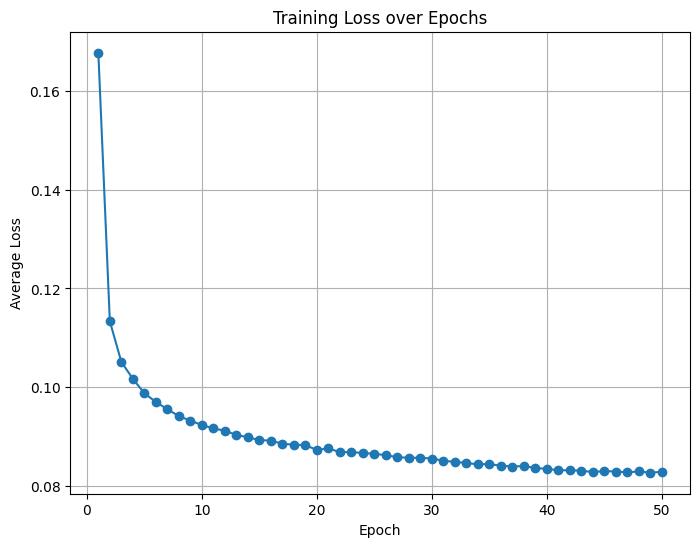

In [ ]:
epoch_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()
        loss = model(x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

    scheduler.step()
    
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f}")

    # Save model every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch+1 == 1:
        torch.save(model.state_dict(), f"./rf_models/model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

print("Training complete!")

# Plotting loss curve
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [13]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    num_images, num_columns = images.shape[0], len(column_names)
    fig, axes = plt.subplots(num_images, num_columns, figsize=(num_columns,num_images))

    for i, axr in enumerate(axes):
        for j, axc in enumerate(axr):
            img = images[i,j].cpu().numpy()  

            axc.imshow(img, cmap='gray')
            axc.axis('off')

            if i == 0:  
                axc.set_title(column_names[j])

    plt.tight_layout(pad=1)
    plt.show()

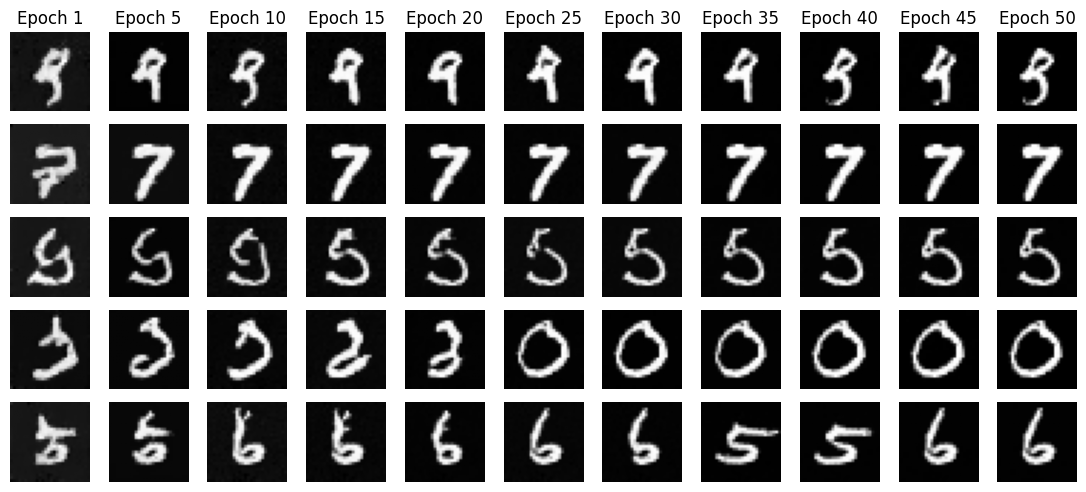

In [17]:
unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
model = RF(unet=unet, num_ts=300).to(device)

epoch_list = [1] + [i for i in range(5, epochs+1, 5)]
sampled_images_list = []
titles = []

for i in epoch_list:
    model.load_state_dict(torch.load(f"./rf_models/model_epoch_{i}.pth"))
    sampled = model.sample(img_wh=(28, 28), seed=5)
    sampled_images_list.append(sampled)
    titles.append(f'Epoch {i}')

all_samples = torch.hstack(sampled_images_list)

axes = visualize_images_with_titles(all_samples, titles)